# Task

Download and process an arbitrary file from Common Crawl (https://index.commoncrawl.org/), extract individual items, perform basic statistical analysis (distribution of hosts, words, languages, domains etc.) and visualization (optional).

# Solution

Please, run jupyter notebook in AcquisitionAndAnalysis directory to give access to prjnlp_utils package.

First, get the link to warc file manually (we should process one warc only, so we don't need to automate this mechanism), using following steps:

0. Open https://index.commoncrawl.org/ page.
0. Download cc-index.paths.gz for February 2019
0. Unpack it, get the first line 'cc-index/collections/CC-MAIN-2019-09/indexes/cdx-00000.gz'. Add to this filename prefix 'https://commoncrawl.s3.amazonaws.com'
0. Download and unpack https://commoncrawl.s3.amazonaws.com/cc-index/collections/CC-MAIN-2019-09/indexes/cdx-00000.gz.
0. Find in unpacked cdx-00000 any warc file name you want. I randomly selected crawl-data/CC-MAIN-2019-09/segments/1550247479627.17/warc/CC-MAIN-20190215224408-20190216010408-00052.warc.gz
0. Add the same prefix https://commoncrawl.s3.amazonaws.com and get the link to the warc file which we will to process further.

https://commoncrawl.s3.amazonaws.com/crawl-data/CC-MAIN-2019-09/segments/1550247479627.17/warc/CC-MAIN-20190215224408-20190216010408-00052.warc.gz

In [1]:
import sys
sys.path.append('..')

import os
from prjnlp_utils import download_with_progress

In [2]:
warc_gz_url: str = \
    'https://commoncrawl.s3.amazonaws.com/crawl-data/CC-MAIN-2019-09/segments/1550247479627.17/warc/CC-MAIN-20190215224408-20190216010408-00052.warc.gz'
archive_name: str = os.path.join(os.getcwd(),
                                 'data/CC-MAIN-20190215224408-20190216010408-00052.warc.gz')


In [3]:
# download wark:

download_with_progress(warc_gz_url, archive_name)

File 'D:\git-nlp\ss-prj-nlp-2019\students\SergeSotnyk\03-data\AcquisitionAndAnalysis\04-Common-Crawl\data\CC-MAIN-20190215224408-20190216010408-00052.warc.gz' is already existed, downloading was skipped.


In [4]:
import gzip
from tqdm.auto import tqdm
from collections import namedtuple, defaultdict
from textblob import TextBlob
import langdetect
from bs4 import BeautifulSoup

SinglePageInfo = namedtuple('SinglePageInfo', ['target_uri', 'server', 'language'])

tokens = defaultdict(int)
langs = defaultdict(int)
uris = set()

def get_text_bs(html):
    tree = BeautifulSoup(html, 'lxml')

    body = tree.body
    if body is None:
        return None

    for tag in body.select('script'):
        tag.decompose()
    for tag in body.select('style'):
        tag.decompose()

    text = body.get_text(separator='\n')
    return text

def process_part(part):
    TARGET_URI_START = 'WARC-Target-URI:'
    if len(part) > 1 and part[1].startswith('WARC-Type: response'):
        html = ''.join(part)
        htmlstart = '<html>'
        pos = html.find(htmlstart)
        if pos >= 0:
            html = html[pos:]
            # txt = h.handle(html)
            txt = get_text_bs(html)
            if not txt:
                return
            blob = TextBlob(txt)
            # blob_lang = blob if len(txt)<2048 else TextBlob(txt[:2048])
            try:
                lang = langdetect.detect(txt if len(txt)<2048 else txt[:2048])
            except:
                lang = 'unknown'
            langs[lang] += 1
            for t in blob.words:
                tokens[t] += 1
            url = next((l for l in part[:20] if l.startswith(TARGET_URI_START)), None)
            if url:
                url = url[len(TARGET_URI_START):].strip()
                uris.add(url)
            

def process_warc_gz(filename: str):
    lines_counter = 0
    res = []
    with gzip.open(filename, 'rt', encoding='utf-8', errors='replace') as f:
        # 52362938 - it is hardcoded value, I've counted it in the first experiment
        part = []

        for line in tqdm(f, total=52362938, unit='lines'):
            lines_counter += 1
            if line.startswith('WARC/1.0'):  # new part started
                if part:
                    process_part(part)
                    # res.append(part)
                part = []
                # if lines_counter>100000:
                #    break
            part.append(line)

        if part:  # last part
            process_part(part)
            # res.append(part)

    print(f"Total lines: {lines_counter}")
    return res


In [5]:
# %load_ext line_profiler
# %lprun -f process_part process_warc_gz(archive_name)
process_warc_gz(archive_name)


Total lines: 52362938


[]

In [6]:
langs_list = sorted([(k, v) for k, v in langs.items() if k.isalnum()], 
                     key=lambda x: -x[1])
print(langs_list)

[('en', 2430), ('ru', 612), ('bn', 600), ('de', 312), ('fr', 193), ('ja', 153), ('es', 148), ('ko', 116), ('unknown', 111), ('nl', 86), ('pl', 81), ('it', 80), ('pt', 69), ('cs', 67), ('tr', 57), ('fa', 45), ('sv', 40), ('id', 33), ('vi', 30), ('ro', 30), ('hu', 29), ('uk', 29), ('da', 24), ('no', 23), ('fi', 22), ('el', 19), ('sk', 18), ('ca', 13), ('bg', 12), ('th', 12), ('ar', 11), ('et', 11), ('tl', 11), ('sl', 10), ('lt', 10), ('he', 9), ('hr', 9), ('af', 5), ('cy', 4), ('lv', 3), ('hi', 2), ('ta', 2), ('so', 1)]


In [7]:
print(f"Total unical tokens {len(tokens)}")
print(f"Total found tokens {sum(c for t, c in tokens.items())}")
tokens_list = sorted([(k, v) for k, v in tokens.items() if k.isalnum()], 
                     key=lambda x: -x[1])
print(f"Cleared tokens {len(tokens_list)}")
print("The most frequent tokens:")
print(tokens_list[:100])

Total unical tokens 692073
Total found tokens 4480496
Cleared tokens 510937
The most frequent tokens:
[('the', 33816), ('a', 29038), ('de', 27265), ('and', 26693), ('to', 23651), ('of', 22964), ('in', 20984), ('1', 19985), ('e', 15579), ('0', 14850), ('for', 13863), ('2', 12928), ('и', 12850), ('la', 10545), ('в', 10392), ('is', 9679), ('di', 9580), ('on', 8940), ('3', 8741), ('en', 8281), ('The', 7530), ('t', 7505), ('4', 7348), ('y', 7241), ('5', 7141), ('baby', 7107), ('que', 7101), ('matras', 7092), ('with', 7061), ('evamat', 7025), ('function', 6984), ('i', 6967), ('return', 6956), ('this', 6816), ('you', 6647), ('на', 6585), ('n', 6316), ('7', 6267), ('by', 6049), ('or', 5945), ('10', 5838), ('if', 5498), ('6', 5491), ('I', 5302), ('that', 5225), ('Found', 5223), ('o', 5207), ('HODGES', 5165), ('s', 5063), ('your', 4961), ('8', 4953), ('el', 4879), ('для', 4867), ('are', 4800), ('r', 4583), ('A', 4343), ('с', 4264), ('be', 4160), ('2019', 4151), ('var', 4133), ('at', 3997), ('fro

In [8]:
from urllib.parse import urlparse
print(f"Total uries {len(uris)}")

domains = defaultdict(int)
fl_domains = defaultdict(int)
for uri in uris:
    d = urlparse(uri).netloc
    domains[str(d)]+=1
    fl_domains[str(d.split('.')[-1])]+=1
    
print(f"Different domains {len(domains)}")
print(f"First-level domains: {len(fl_domains)}")

fl_domains_list = sorted([(k, v) for k, v in fl_domains.items() if k.isalnum()], 
                     key=lambda x: -x[1])
print(fl_domains_list)

Total uries 5899
Different domains 5184
First-level domains: 156
[('com', 2533), ('ru', 633), ('org', 279), ('net', 256), ('de', 205), ('cn', 142), ('uk', 111), ('jp', 104), ('info', 79), ('ua', 78), ('nl', 74), ('pl', 71), ('cz', 69), ('it', 60), ('eu', 57), ('fr', 48), ('br', 46), ('ca', 44), ('se', 38), ('ir', 37), ('kr', 36), ('by', 35), ('tw', 35), ('ch', 31), ('au', 31), ('in', 29), ('es', 28), ('edu', 28), ('hu', 26), ('su', 25), ('co', 22), ('gr', 21), ('dk', 21), ('sk', 21), ('tv', 20), ('be', 20), ('biz', 19), ('us', 19), ('fi', 19), ('gov', 19), ('ro', 18), ('io', 17), ('vn', 17), ('at', 16), ('mx', 15), ('no', 13), ('za', 13), ('pt', 12), ('lt', 11), ('ee', 11), ('tr', 10), ('xyz', 10), ('kz', 10), ('club', 9), ('il', 9), ('cc', 8), ('bg', 7), ('id', 7), ('me', 7), ('si', 7), ('ie', 7), ('hk', 7), ('ar', 6), ('nz', 6), ('tl', 6), ('am', 5), ('fm', 5), ('site', 4), ('pw', 4), ('lv', 4), ('top', 4), ('hr', 4), ('az', 4), ('tk', 4), ('link', 4), ('ec', 3), ('pro', 3), ('to', 3

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


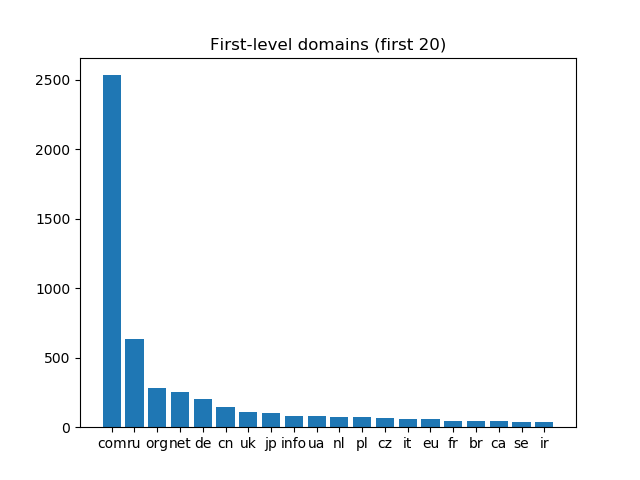

In [43]:
%matplotlib notebook

import matplotlib.pyplot as plt

d = fl_domains_list[:20]
labels = [k for k, v in d]
values = [v for k, v in d]

#plt.bar(labels, height=values, tick_label = labels)

#plt.title('First-level domains (first 20)')

#plt.show()

#plt.plot(x=[k for k, v in d],
#            y=[v for k, v in d])

fig, ax = plt.subplots()

ax.set_title('First-level domains (first 20)')
# print(dir(ax))
ax.bar(labels, values)
fig.show()

<IPython.core.display.Javascript object>


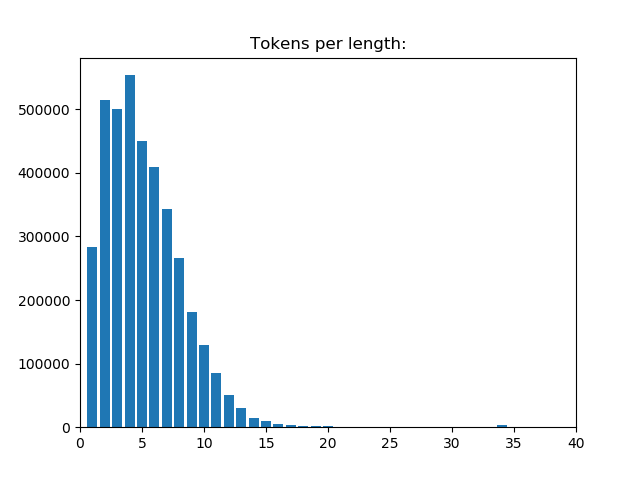

In [44]:
tokens_per_length_dic = defaultdict(int)
for t, c in tokens_list:
    tokens_per_length_dic[len(t)]+=c
    
labels = [k for k, v in tokens_per_length_dic.items()]
values = [v for k, v in tokens_per_length_dic.items()]

fig, ax = plt.subplots()
ax.bar(labels, values)

ax.set_title('Tokens per length:')
ax.set_xlim(0, 40)

fig.show()


P.S.: When I was finishing this notebook, I've found following sample of warc processing: https://rushter.com/blog/python-fast-html-parser/

I've used only get_text_bs function from this code, because selectolax library brakes up my jupiter kernel. The most interesting thing in the article is line "import warc". I don't use this package in my work, but maybe I'll use it later for processing warcs.